In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ner-cadec-deasendrug/processed_data/drug_disease/train_texts.txt
/kaggle/input/ner-cadec-deasendrug/processed_data/drug_disease/test_texts.txt
/kaggle/input/ner-cadec-deasendrug/processed_data/drug_disease/tagset.txt
/kaggle/input/ner-cadec-deasendrug/processed_data/drug_disease/conll_drug_disease.txt
/kaggle/input/ner-cadec-deasendrug/processed_data/drug_disease/README
/kaggle/input/ner-cadec-deasendrug/processed_data/drug_disease/train_labels.txt
/kaggle/input/ner-cadec-deasendrug/processed_data/drug_disease/train_gazetteers.txt
/kaggle/input/ner-cadec-deasendrug/processed_data/drug_disease/test_labels.txt
/kaggle/input/ner-cadec-deasendrug/processed_data/drug_disease/test_gazetteers.txt


In [2]:
import tensorflow
import sklearn
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model,Sequential,load_model
from tensorflow.keras.layers import Input,Conv1D,LSTM,GRU,Dense,Embedding,Bidirectional,GaussianDropout,TimeDistributed
from tensorflow.keras.layers import SpatialDropout1D,MaxPooling2D
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow.keras

from sklearn.metrics import classification_report, accuracy_score,confusion_matrix
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import pickle
import numpy as np

import tensorflow as tf
import re
from ast import literal_eval

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Cấu hình bộ nhớ GPU
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*14)])
    except RuntimeError as e:
        # Tránh lỗi khi không đủ bộ nhớ GPU
        print(e)

**Read DATA**

In [4]:
def readScroll(path):
    with open(path,'r') as f:
        data = f.read()
    data = data.split('\n')
    Sequences = []
    labels    = []
    seq   = []
    label = []
    for line in data:
        if len(line.split())==2:
            if line.split()[0] != '.':
                seq.append(line.split()[0])
                label.append(line.split()[1])
            else:
                seq.append(line.split()[0])
                label.append(line.split()[1])
                Sequences.append(" ".join(seq))
                labels.append(" ".join(label))
                seq.clear()
                label.clear()
    return Sequences,labels

def readListPath(path_list):
    with open(path_list[0],'r') as f:
        data_test_text = f.read()
    with open(path_list[1],'r') as f:
        data_test_label = f.read()
    data_test_text = data_test_text.split('\n')
    data_test_label = data_test_label.split('\n')

#     len(data_test_text),len(data_test_label)
    data_test_sequences = []
    data_test_tagets = []
    for i in range(len(data_test_text)):
        data_split_texts = data_test_text[i].split()
        data_split_tagets = data_test_label[i].split()
        setence = []
        taget = []
        for i, word in enumerate(data_split_texts) :
            if(word == '.'):
                setence.append(word) 
                taget.append(data_split_tagets[i])
                data_test_sequences.append(" ".join(setence))
                data_test_tagets.append(" ".join(taget))
                setence.clear()
                taget.clear()
            else:
                setence.append(word) 
                taget.append(data_split_tagets[i])
#     len(data_test_sequences),len(data_test_tagets)
    return data_test_sequences,data_test_tagets


In [5]:
path = '/kaggle/input/ner-cadec-deasendrug/processed_data/drug_disease/conll_drug_disease.txt'
Sequences_val,labels_val = readScroll(path)
length_seq = [len(seq.split()) for seq in Sequences_val ]
max(length_seq)

236

In [6]:
pad_len = max(length_seq)

In [7]:
path_test_text = '/kaggle/input/ner-cadec-deasendrug/processed_data/drug_disease/train_texts.txt'
path_test_label = '/kaggle/input/ner-cadec-deasendrug/processed_data/drug_disease/train_labels.txt'
path_list = [path_test_text,path_test_label]
Sequences_train,labels_train = readListPath(path_list)

**Tokenizer and padding**

In [8]:
tokenizer_data = Tokenizer(oov_token = '<OOV>',filters= '', split = ' ')
tokenizer_data.fit_on_texts(Sequences_train)
tokenizer_data_text = tokenizer_data.texts_to_sequences(Sequences_train)
# vec_data = pad_sequences(tokenizer_data_text,padding = 'post')
vec_data = pad_sequences(tokenizer_data_text,maxlen = pad_len)

In [9]:
len(tokenizer_data.word_index)

5968

In [10]:
taget_idx = { '<PAD>':0,'O':1,'B-Disease':2,'B-Drug':3,'I-Disease':4,'I-Drug':5}
idx_taget = ['<PAD>','O','B-Disease','B-Drug','I-Disease','I-Drug']
tokenizer_taget_text = []
for setence in labels_train:
    seq = [taget_idx[word] for word in setence.split()]
    tokenizer_taget_text.append(seq)
# vec_taget = pad_sequences(tokenizer_taget_text,padding = 'post')
vec_taget = pad_sequences(tokenizer_taget_text,maxlen=pad_len)

In [11]:
vec_taget.shape,vec_data.shape

((5005, 236), (5005, 236))

**MAP length sequence**

In [12]:
# import matplotlib.pyplot as plt
# from collections import defaultdict
# freq_dict = defaultdict(int)
# for length in length_seq:
#     freq_dict[length] += 1

# # Vẽ biểu đồ cột
# plt.bar(freq_dict.keys(), freq_dict.values())
# plt.xlabel('Độ dài câu')
# plt.ylabel('Số lượng câu')
# plt.show()

**Tag**

In [13]:
# taget_idx = {'O':0,'B-Disease':1,'B-Drug':2,'I-Disease':3,'I-Drug':4}
# idx_taget = ['O','B-Disease','B-Drug','I-Disease','I-Drug']
# taget_idx = {'O':0,'B-DIS':1,'B-DRUG':2,'I-DIS':3,'I-DRUG':4}
# idx_taget = ['O','B-DIS','B-DRUG','I-DIS','I-DRUG']

**Build dataset**

# **Build Model trainformer**

**Liblary**

In [14]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from datasets import load_dataset
# from collections import Counter
# from conlleval import evaluate

**trainformer block**

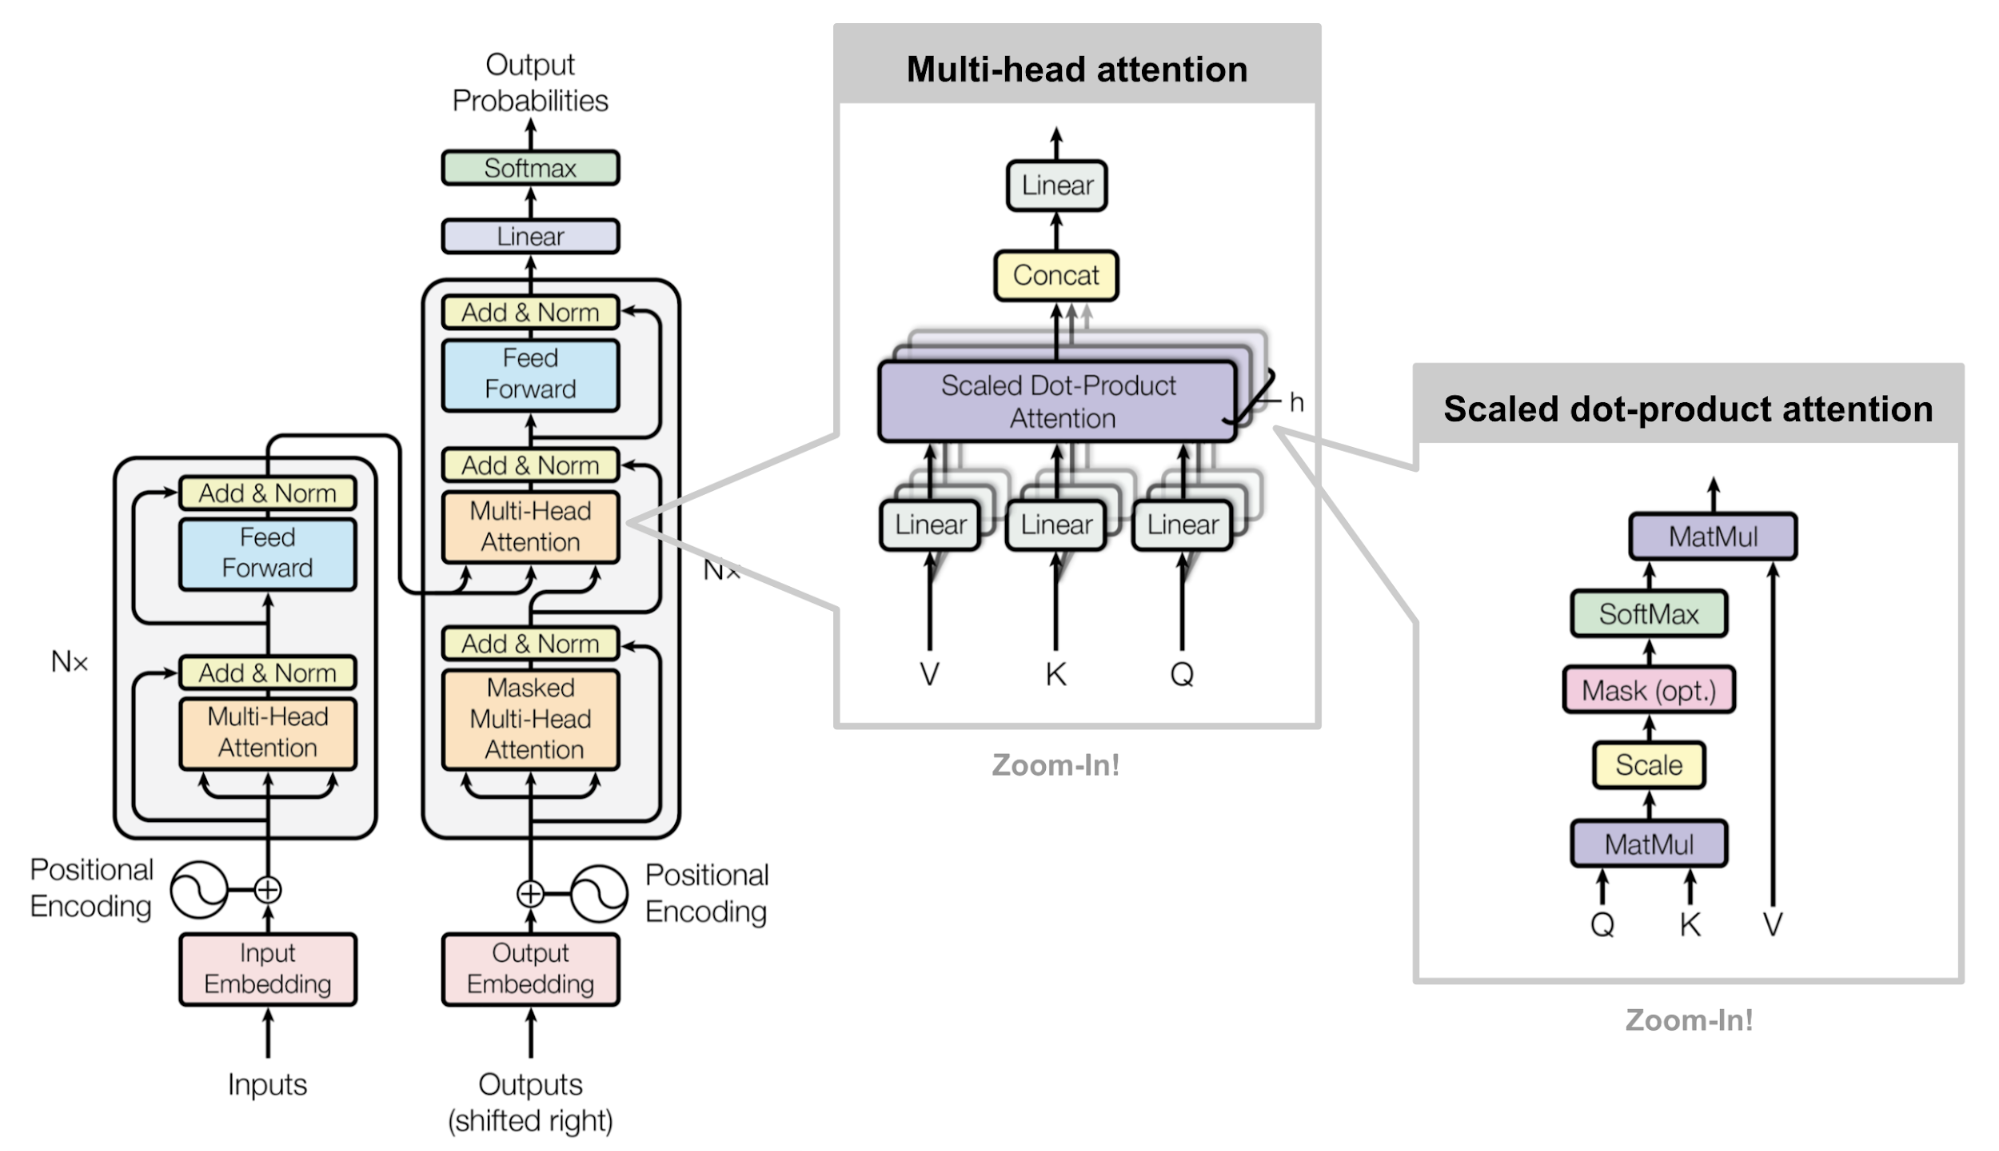

In [15]:
from keras import layers

In [16]:
class TrainformerBlock(layers.Layer):
    """
    trong block trainformer đầu vào inputs
        input đi qua lớp multi-head_attention tạo ra output
        kết hợp (output+inputs) tạo đầu vào cho LayerNormalization tạo ra out1
        
        out1 thanh đầu vào cho feedforword tạo thành ffn_out
        ffn_out+out1  thành đầu vào cho LayerNormalization
        
    
    """
    
    def __init__(self,embed_dim,num_heads,ff_dim,rate = 0.01):
        super().__init__()
        self.att = keras.layers.MultiHeadAttention(num_heads=num_heads,key_dim = embed_dim)
        self.ffn = keras.Sequential(
                [
                keras.layers.Dense(ff_dim, activation="relu"),
                keras.layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = keras.layers.Dropout(rate) 
        self.dropout2 = keras.layers.Dropout(rate) 
    def __call__(self,inputs,training = False):
        attn_output = self.att(inputs,inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs+attn_output)
        ffn_out = self.ffn(out1)
        ffn_out = self.dropout2(ffn_out, training=training)
        out2 =  self.layernorm2(out1+ffn_out)
        return out2

**Position embedding**

In [17]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self,maxlen,vocab_size,embed_dim):
        super().__init__()
        self.token_emb = keras.layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim, trainable=True
        )
        self.pos_emb = keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim)
    def __call__(self,inputs):
        maxlen = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        position_embeddings = self.pos_emb(positions)
        token_embeddings = self.token_emb(inputs)
        return token_embeddings + position_embeddings

**Ner MODEL**

In [18]:
class NerModel(keras.Model):
    def __init__(self,num_tags,vocab_size,maxlen = 128,embed_dim = 32,num_heads = 2,ff_dim = 32):
        super().__init__()
        self.num_tags = num_tags
        self.embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
        self.transformer_block = TrainformerBlock(embed_dim, num_heads, ff_dim)
        self.dropout1 = layers.Dropout(0.1)
        self.ff = layers.Dense(ff_dim, activation="relu")
        self.dropout2 = layers.Dropout(0.1)
        self.ff_final = layers.Dense(num_tags, activation="softmax")
    def __call__(self,inputs,training = False):
        x = self.embedding_layer(inputs)
        x = self.transformer_block(x)
        x = self.dropout1(x, training=training)
        x = self.ff(x)
        x = self.dropout2(x, training=training)
        x = self.ff_final(x)
        return x
        
            

In [19]:
num_tags = len(taget_idx)
vocab_size = len(tokenizer_data.word_index)+1
BATCH_SIZE = 16

In [20]:
class CustomNonPaddingTokenLoss(keras.losses.Loss):
    def __init__(self, name="custom_ner_loss"):
        super().__init__(name=name)

    def call(self, y_true, y_pred):
        loss_fn = keras.losses.SparseCategoricalCrossentropy(
            from_logits=True, reduction=keras.losses.Reduction.NONE
        )
        loss = loss_fn(y_true, y_pred)
        mask = tf.cast((y_true > 0), dtype=tf.float32)
        loss = loss * mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)


In [21]:
train_dataset = tf.data.Dataset.from_tensor_slices((vec_data, vec_taget))
train_dataset = train_dataset.batch(BATCH_SIZE)

In [22]:
ner_model = NerModel(num_tags, vocab_size,maxlen  = pad_len, embed_dim=40, num_heads=12, ff_dim=64)

In [23]:
# # Allow GPU memory growth
# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [24]:
loss = CustomNonPaddingTokenLoss()
ner_model.compile(optimizer="adam", loss=loss)
with tf.device('/GPU:0'):
    history = ner_model.fit(train_dataset, epochs=30)

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


313/313 [==============================] - 33s 87ms/step - loss: 0.4450
Epoch 2/30
313/313 [==============================] - 4s 11ms/step - loss: 0.2862
Epoch 3/30
313/313 [==============================] - 4s 11ms/step - loss: 0.2524
Epoch 4/30
313/313 [==============================] - 4s 11ms/step - loss: 0.2399
Epoch 5/30
313/313 [==============================] - 4s 12ms/step - loss: 0.2259
Epoch 6/30
313/313 [==============================] - 4s 11ms/step - loss: 0.2060
Epoch 7/30
313/313 [==============================] - 4s 11ms/step - loss: 0.1895
Epoch 8/30
313/313 [==============================] - 4s 12ms/step - loss: 0.1753
Epoch 9/30
313/313 [==============================] - 4s 13ms/step - loss: 0.1631
Epoch 10/30
313/313 [==============================] - 4s 11ms/step - loss: 0.1510
Epoch 11/30
313/313 [==============================] - 4s 12ms/step - loss: 0.1408
Epoch 12/30
313/313 [==============================] - 4s 11ms/step - loss: 0.1311
Epoch 13/30
313/313 [==

In [25]:
import torch
def report_score(dataloader):
    all_predictions = []
    all_labels = []
    all_logits = []
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    
    for val_data, val_label in dataloader:
    
#         val_label = val_label.to(device)
#         mask = val_data['attention_mask'].squeeze(1).to(device)
#         input_id = val_data['input_ids'].squeeze(1).to(device)

        logits = ner_model(val_data)

        for i in range (logits.shape[0]):
            logits_clean = logits[i][val_label[i] != 0]
#             predictions = logits_clean.argmax(dim=1).tolist()
            predictions =  tf.argmax(logits_clean, axis=1).numpy().tolist()
            all_predictions.extend(predictions)
            label_clean = val_label[i][val_label[i] != 0]
#             all_labels.extend(label_clean.tolist())
            all_labels.extend(label_clean.numpy().tolist())

    all_predictions_arr = np.array(all_predictions) 
    all_labels_arr = np.array(all_labels)
    print(classification_report(all_labels_arr, all_predictions_arr,target_names=idx_taget[1:]))

In [26]:
report_score(train_dataset)

              precision    recall  f1-score   support

           O       0.98      1.00      0.99     70900
   B-Disease       0.95      0.92      0.94      4252
      B-Drug       0.99      1.00      0.99      1207
   I-Disease       0.97      0.82      0.89      6106
      I-Drug       0.94      0.98      0.96       141

    accuracy                           0.98     82606
   macro avg       0.97      0.94      0.95     82606
weighted avg       0.98      0.98      0.98     82606



In [27]:
Sequences_val,labels_val 

tokenizer_test_text = tokenizer_data.texts_to_sequences(Sequences_val)
# vec_data = pad_sequences(tokenizer_data_text,padding = 'post')
vec_data_test = pad_sequences(tokenizer_test_text,maxlen = pad_len)

# taget_idx = { '<PAD>':0,'O':1,'B-Disease':2,'B-Drug':3,'I-Disease':4,'I-Drug':5}
# idx_taget = ['<PAD>','O','B-Disease','B-Drug','I-Disease','I-Drug']
tokenizer_test_taget = []
for setence in labels_val:
    seq = [taget_idx[word] for word in setence.split()]
    tokenizer_test_taget.append(seq)
# vec_taget = pad_sequences(tokenizer_taget_text,padding = 'post')
vec_taget_test = pad_sequences(tokenizer_test_taget,maxlen=pad_len)


test_dataset = tf.data.Dataset.from_tensor_slices((vec_data_test, vec_taget_test))
test_dataset = test_dataset.batch(BATCH_SIZE)


In [28]:
report_score(test_dataset)

              precision    recall  f1-score   support

           O       0.97      0.99      0.98    102813
   B-Disease       0.85      0.79      0.82      6151
      B-Drug       0.96      0.96      0.96      1755
   I-Disease       0.84      0.66      0.74      8797
      I-Drug       0.79      0.80      0.80       196

    accuracy                           0.95    119712
   macro avg       0.88      0.84      0.86    119712
weighted avg       0.95      0.95      0.95    119712

